In [12]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [13]:
def c6_data():
    df = pd.read_csv('data.csv')
    df.drop_duplicates(inplace=True)

    x = df.iloc[:, :2].values
    y = df.iloc[:, 2].values

    # 归一化
    scaler_x = StandardScaler()
    x = scaler_x.fit_transform(x)

    scaler_y = StandardScaler()
    y = y.reshape(-1, 1)
    y = scaler_y.fit_transform(y)

    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=666)

    return x_train, x_test, y_train, y_test, scaler_x, scaler_y

# 获取数据
x_train, x_test, y_train, y_test, scaler_x, scaler_y = c6_data()


In [14]:
# 假设每个样本有10个时间步长
sequence_length = 10

# 生成时间序列数据
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# 创建训练和测试序列
x_train_seq = create_sequences(x_train, sequence_length)
x_test_seq = create_sequences(x_test, sequence_length)

# 调整 y_train 和 y_test 的形状以匹配序列
y_train_seq = y_train[sequence_length - 1:]
y_test_seq = y_test[sequence_length - 1:]


In [ ]:
# 加载模型
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Model loaded from disk.")
else:
    print("Model file not found.")


In [15]:
# 定义 LSTM 模型
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, x_train_seq.shape[2]), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])


In [16]:
# 训练模型
history = model.fit(x_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(x_test_seq, y_test_seq))


Epoch 1/20


2024-11-15 23:39:26.148143: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe8a5222250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-15 23:39:26.148166: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-15 23:39:26.152706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 23:39:26.280811: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2589/2589 [==============================] - 13s 4ms/step - loss: 0.1341 - mae: 0.2552 - val_loss: 0.0826 - val_mae: 0.2041
Epoch 2/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0832 - mae: 0.2098 - val_loss: 0.0815 - val_mae: 0.2086
Epoch 3/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0810 - mae: 0.2046 - val_loss: 0.0782 - val_mae: 0.1997
Epoch 4/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0793 - mae: 0.2009 - val_loss: 0.0767 - val_mae: 0.1982
Epoch 5/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0779 - mae: 0.1982 - val_loss: 0.0804 - val_mae: 0.1992
Epoch 6/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0770 - mae: 0.1962 - val_loss: 0.0779 - val_mae: 0.1959
Epoch 7/20
2589/2589 [==============================] - 9s 4ms/step - loss: 0.0767 - mae: 0.1959 - val_loss: 0.0757 - val_mae: 0.1957
Epoch 8/20
2589/2589 [==============================] - 9s 4ms/step - lo

In [17]:
# 保存模型权重
model.save_weights('lstmmodel/lstm_weights.h5')

# 创建存储scaler的文件夹
scaler_folder = os.path.join('lstmmodel', 'scalers')
os.makedirs(scaler_folder, exist_ok=True)

# 保存scaler
joblib.dump(scaler_x, os.path.join(scaler_folder, 'scaler_x.pkl'))
joblib.dump(scaler_y, os.path.join(scaler_folder, 'scaler_y.pkl'))


['lstmmodel/scalers/scaler_y.pkl']

In [18]:
# 预测并计算额外的指标
y_pred = model.predict(x_test_seq)

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test_seq, y_pred)
print(f"MSE: {mse}")

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# 计算平均绝对误差 (MAE)
mae = mean_absolute_error(y_test_seq, y_pred)
print(f"MAE: {mae}")

# 计算 R²
r2 = r2_score(y_test_seq, y_pred)
print(f"R²: {r2}")


647/647 [==============================] - 1s 1ms/step
MSE: 0.0740289419758726
RMSE: 0.2720826013839779
MAE: 0.18951886151736597
R²: 0.9265952120775854


In [19]:
model.save('lstmmodel.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# 保存模型
model_path = './lstmmodel/model_lstm_weight'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
model.save(model_path)
print("Model saved to disk.")


INFO:tensorflow:Assets written to: ./lstmmodel/model_lstm_weight/assets


INFO:tensorflow:Assets written to: ./lstmmodel/model_lstm_weight/assets


Model saved to disk.


损失图已保存到: lstm_fig/lstm_loss_plot.png
局部放大损失图已保存到: lstm_fig/zoom_loss_plot.png


/tmp/ipykernel_846/2785549300.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: lstm_fig/combined_plot_zoomed.png


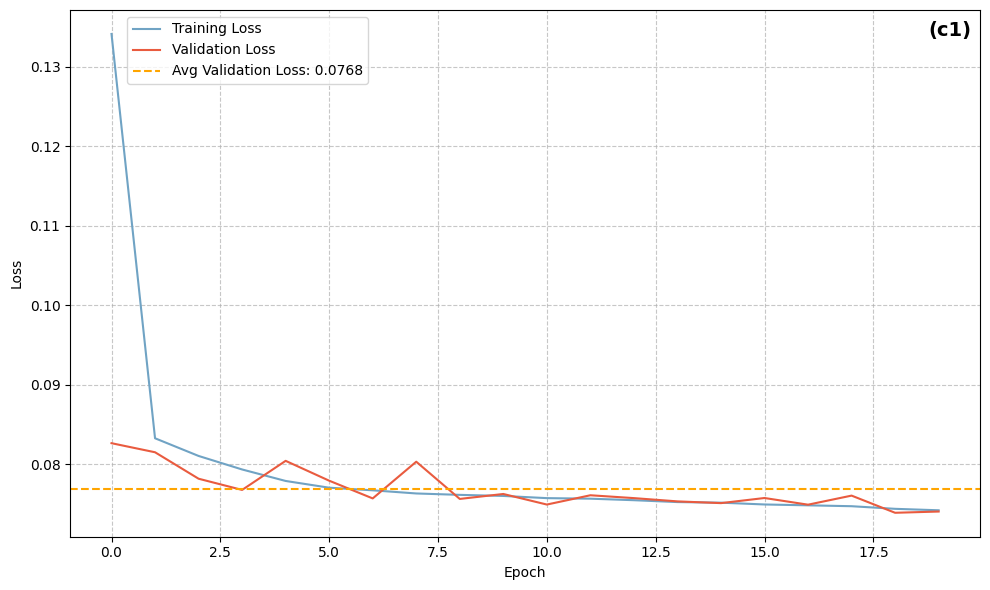

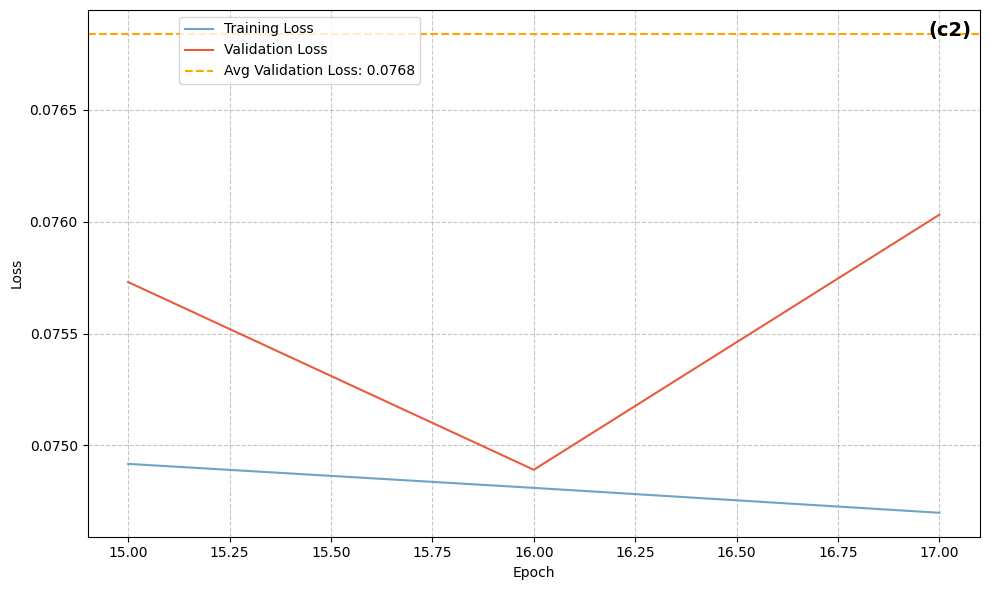

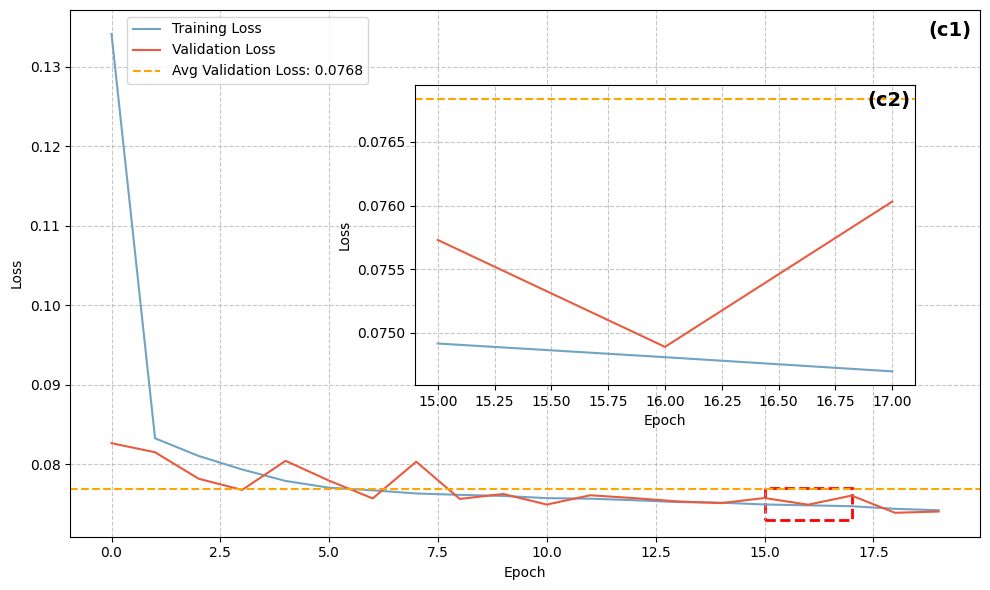

In [21]:
# 获取训练和验证 MAE
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# 获取训练和验证损失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 计算平均验证损失和MAE
avg_val_loss = np.mean(val_loss)
avg_val_mae = np.mean(val_mae)

# 计算损失的变化率
loss_diff = np.diff(val_loss)
max_diff_index = np.argmax(np.abs(loss_diff))

# 自定义放大区间
zoom_epoch_start = 15  # 自定义起始 epoch
zoom_epoch_end = 18   # 自定义结束 epoch

# 自定义虚线框高度和宽度
rect_y_min = 0.073  # 自定义虚线框的下边界
rect_y_max = 0.077  # 自定义虚线框的上边界
rect_x_start = 15   # 自定义虚线框的左边界
rect_x_end = 17      # 自定义虚线框的右边界

# 创建保存图片的文件夹
folder_name = "lstm_fig"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 绘制损失图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(c1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'lstm_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 绘制局部放大图
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(c2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图，将局部放大图嵌入到主图中
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(c1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 嵌入放大损失图
inset_ax = fig.add_axes([0.42, 0.35, 0.5, 0.5])  # [left, bottom, width, height]
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')  # 添加平均值线
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.98, '(c2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')


# 添加红色虚线框
rect = plt.Rectangle((rect_x_start, rect_y_min), 
                     rect_x_end - rect_x_start, 
                     rect_y_max - rect_y_min, 
                     edgecolor='red', linestyle='--', linewidth=2, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'combined_plot_zoomed.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# 显示图表
plt.show()

78/78 [==============================] - 0s 2ms/step


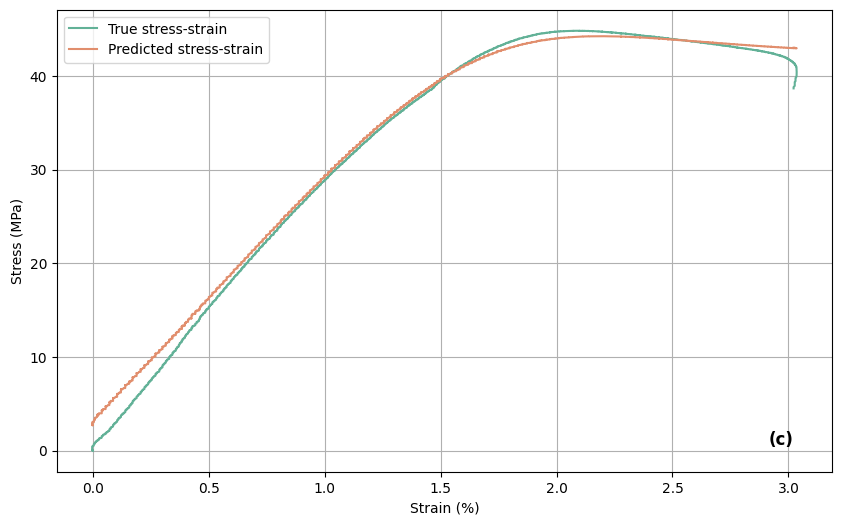

In [24]:

# 确保保存图片的文件夹存在
folder_path = os.path.join('lstm_fig', 'prediction')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


# 加载保存的scaler
scaler_x = joblib.load(os.path.join('lstmmodel', 'scalers', 'scaler_x.pkl'))
scaler_y = joblib.load(os.path.join('lstmmodel', 'scalers', 'scaler_y.pkl'))

# 读取新数据
file_name = 'Angle_group_5.csv'
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值
stress_true = df_new_data.iloc[:, 2].values  # 第三列为真实应力值

# 对新数据进行归一化处理
x_new = df_new_data.iloc[:, :2].values  # 取前两列作为输入特征
x_new_scaled = scaler_x.transform(x_new)

# 创建新数据序列
x_new_seq = create_sequences(x_new_scaled, sequence_length)

# 进行预测
y_pred_scaled = model.predict(x_new_seq)

# 将预测值逆归一化，恢复到原始尺度
stress_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# 确保预测值和实际值的长度相同
min_length = min(len(strain), len(stress_pred))
strain_truncated = strain[:min_length]
stress_true_truncated = stress_true[:min_length]
stress_pred_truncated = stress_pred[:min_length]

# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_truncated, stress_true_truncated, label='True stress-strain', color='#62B197')
plt.plot(strain_truncated, stress_pred_truncated, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
# plt.title('True vs Predicted Stress-Strain Curve')
plt.grid(True)
# 在右下角添加文本 (b1)
plt.text(0.95, 0.05, '(c)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='bottom')
# 保存图片
plt.savefig(os.path.join(folder_path, 'predicted_vs_true_stress_strain.png'))
plt.show()


In [ ]:
# 反归一化预测值和真实值
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_seq_inv = scaler_y.inverse_transform(y_test_seq)

# 绘制预测值和真实值的折线图
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq_inv, label='True Values', color='blue')
plt.plot(y_pred_inv, label='Predicted Values', color='orange')
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()
plt.savefig('Triue and Predicted Values.png')

In [ ]:
from scipy.signal import savgol_filter

# 计算每个时间步的 MAE
mae_per_timestep = np.abs(y_test_seq - y_pred).mean(axis=1)

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate = 90
mae_sampled = mae_per_timestep[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per timestep', color='#4493C4', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.1  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='#4493C4', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (a)
plt.text(0.95, 0.95, '(c)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Time step (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
mae_timestep_path = './lstm_fig/mae_per_timestep.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per timestep plot saved and displayed: {mae_timestep_path}")